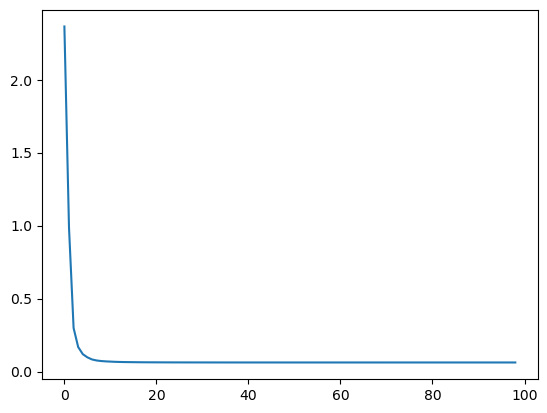

In [7]:
import haiku as hk
import jax
import jax.numpy as jnp
import kfac_jax

# Hyper parameters
NUM_CLASSES = 10
L2_REG = 1e-3
NUM_BATCHES = 100


def make_dataset_iterator(batch_size):
  # Dummy dataset, in practice this should be your dataset pipeline
  for _ in range(NUM_BATCHES):
    yield jnp.zeros([batch_size, 100]), jnp.ones([batch_size], dtype="int32")


def softmax_cross_entropy(logits: jnp.ndarray, targets: jnp.ndarray):
  """Softmax cross entropy loss."""
  # We assume integer labels
  assert logits.ndim == targets.ndim + 1

  # Tell KFAC-JAX this model represents a classifier
  # See https://kfac-jax.readthedocs.io/en/latest/overview.html#supported-losses
  kfac_jax.register_softmax_cross_entropy_loss(logits, targets)
  log_p = jax.nn.log_softmax(logits, axis=-1)
  return - jax.vmap(lambda x, y: x[y])(log_p, targets)


def model_fn(x):
  """A Haiku MLP model function - three hidden layer network with tanh."""
  return hk.nets.MLP(
    output_sizes=(50, 50, 50, NUM_CLASSES),
    with_bias=True,
    activation=jax.nn.tanh,
  )(x)


# The Haiku transformed model
hk_model = hk.without_apply_rng(hk.transform(model_fn))


def loss_fn(model_params, model_batch):
  """The loss function to optimize."""
  x, y = model_batch
  logits = hk_model.apply(model_params, x)
  loss = jnp.mean(softmax_cross_entropy(logits, y))

  # The optimizer assumes that the function you provide has already added
  # the L2 regularizer to its gradients.
  return loss + L2_REG * kfac_jax.utils.inner_product(params, params) / 2.0


# Create the optimizer
optimizer = kfac_jax.Optimizer(
  value_and_grad_func=jax.value_and_grad(loss_fn),
  l2_reg=L2_REG,
  value_func_has_aux=False,
  value_func_has_state=False,
  value_func_has_rng=False,
  use_adaptive_learning_rate=True,
  use_adaptive_momentum=True,
  use_adaptive_damping=True,
  initial_damping=1.0,
  multi_device=False,
)

input_dataset = make_dataset_iterator(128)
rng = jax.random.PRNGKey(42)
dummy_images, dummy_labels = next(input_dataset)
rng, key = jax.random.split(rng)
params = hk_model.init(key, dummy_images)
rng, key = jax.random.split(rng)
opt_state = optimizer.init(params, key, (dummy_images, dummy_labels))

loss = []

# Training loop
for i, batch in enumerate(input_dataset):
  rng, key = jax.random.split(rng)
  params, opt_state, stats = optimizer.step(
      params, opt_state, key, batch=batch, global_step_int=i)
  loss.append(stats['loss'])

import matplotlib.pyplot as plt
plt.plot(loss)

In [8]:
"""Type definitions that can be reused across the VMCNet codebase.

Because type-checking with numpy/jax numpy can be tricky and does not always agree with
type-checkers, this package uses types for static type-checking when possible, but
otherwise they are intended for documentation and clarity.
"""
from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple, TypeVar, Union

from jax import Array
from jax.typing import ArrayLike
import kfac_jax
import optax

# Currently using PyTree = Any just to improve readability in the code.
# A pytree is a "tree-like structure built out of container-like Python objects": see
# https://jax.readthedocs.io/en/latest/pytrees.html
PyTree = Any

# TypeVar for an arbitrary PyTree
T = TypeVar("T", bound=PyTree)

# TypeVar for a pytree containing MCMC data, e.g. walker positions
# and wave function amplitudes, or other auxiliary MCMC data
D = TypeVar("D", bound=PyTree)

# TypeVar for MCMC metadata which is required to take a metropolis step.
M = TypeVar("M", bound=PyTree)

# TypeVar for a pytree containing model params
P = TypeVar("P", bound=PyTree)

# TypeVar for a pytree containing optimizer state
S = TypeVar("S", bound=PyTree)

# Actual optimizer states currently used
# TODO: Figure out how to make kfac_opt.State not be interpreted by mypy as Any
OptimizerState = Union[kfac_jax.optimizer.OptimizerState, optax.OptState]

LearningRateSchedule = Callable[[Array], Array]

ModelParams = Dict[str, Any]

# VMC state needed for a checkpoint. Values are:
#  1. The epoch
#  2. The MCMC walker data
#  3. The model parameters
#  4. The optimizer state
#  5. The RNG key
#CheckpointData = Tuple[int, D, P, S, PRNGKey]

ArrayList = List[Array]

# Single array in (sign, logabs) form
SLArray = Tuple[Array, Array]

SLArrayList = List[SLArray]

ParticleSplit = Union[int, Sequence[int]]

InputStreams = Tuple[Array, Optional[Array], Optional[Array], Optional[Array]]
ComputeInputStreams = Callable[[Array], InputStreams]

Backflow = Callable[[Array, Optional[Array]], Array]

Jastrow = Callable[[Array, Array, Array, Array, Array], Array]

ModelApply = Callable[[P, Array], Array]
#LocalEnergyApply = Callable[[P, Array, Optional[PRNGKey]], Array]

GetPositionFromData = Callable[[D], Array]
GetAmplitudeFromData = GetPositionFromData[D]
UpdateDataFn = Callable[[D, P], D]

ClippingFn = Callable[[Array, ArrayLike], Array]

In [9]:
## Required code for the Spring optimizer
import functools
from typing import Callable
from jax import core

def wrap_if_pmap(p_func: Callable) -> Callable:
    """Make a function run if in a pmapped context."""

    def p_func_if_pmap(obj, axis_name):
        try:
            core.axis_frame(axis_name)
            return p_func(obj, axis_name)
        except NameError:
            return obj

    return p_func_if_pmap

pmean_if_pmap = functools.partial(wrap_if_pmap(jax.lax.pmean), axis_name="pmap_axis")

"""Helper functions for pytrees."""
import chex
import jax.flatten_util


def tree_sum(tree1: T, tree2: T) -> T:
    """Leaf-wise sum of two pytrees with the same structure."""
    return jax.tree_map(lambda a, b: a + b, tree1, tree2)


def tree_diff(tree1: T, tree2: T) -> T:
    """Leaf-wise sum of two pytrees with the same structure."""
    return jax.tree_map(lambda a, b: a - b, tree1, tree2)


def tree_dist(tree1: T, tree2: T, mode="squares") -> Array:
    """Distance between two pytrees with the same structure."""
    dT = tree_diff(tree1, tree2)
    if mode == "squares":
        return tree_inner_product(dT, dT)
    raise ValueError(f"Unknown mode {mode}")


def tree_prod(tree1: T, tree2: T) -> T:
    """Leaf-wise product of two pytrees with the same structure."""
    return jax.tree_map(lambda a, b: a * b, tree1, tree2)


def multiply_tree_by_scalar(tree: T, scalar: chex.Numeric) -> T:
    """Multiply all leaves of a pytree by a scalar."""
    return jax.tree_map(lambda x: scalar * x, tree)


def tree_inner_product(tree1: T, tree2: T) -> Array:
    """Inner product of two pytrees with the same structure."""
    leaf_inner_prods = jax.tree_map(lambda a, b: jnp.sum(a * b), tree1, tree2)
    return jnp.sum(jax.flatten_util.ravel_pytree(leaf_inner_prods)[0])


def tree_reduce_l1(xs: PyTree) -> chex.Numeric:
    """L1 norm of a pytree as a flattened vector."""
    concat_xs, _ = jax.flatten_util.ravel_pytree(xs)
    return jnp.sum(jnp.abs(concat_xs))

In [10]:
"""Stochastic reconfiguration (SR) routine."""
import jax
import jax.flatten_util
import jax.numpy as jnp

#from vmcnet.utils.typing import Array, ModelApply, P, Tuple

import chex



def get_spring_update_fn(
    log_psi_apply: ModelApply[P],
    damping: chex.Scalar = 0.001,
    mu: chex.Scalar = 0.99,
    momentum: chex.Scalar = 0.0,
):
    """
    Get the SPRING update function.

    Args:
        log_psi_apply (Callable): computes log|psi(x)|, where the signature of this
            function is (params, x) -> log|psi(x)|
        damping (float): damping parameter
        mu (float): SPRING-specific regularization

    Returns:
        Callable: SPRING update function. Has the signature
        (centered_energies, params, prev_grad, positions) -> new_grad
    """

    def raveled_log_psi_grad(params: P, positions: Array) -> Array:
        log_grads = jax.grad(log_psi_apply)(params, positions)
        return jax.flatten_util.ravel_pytree(log_grads)[0]

    batch_raveled_log_psi_grad = jax.vmap(raveled_log_psi_grad, in_axes=(None, 0))

    def spring_update_fn(
        centered_energies: P,
        params: P,
        prev_grad,
        positions: Array,
    ) -> Tuple[Array, P]:
        nchains = positions.shape[0]

        prev_grad, unravel_fn = jax.flatten_util.ravel_pytree(prev_grad)
        prev_grad_decayed = mu * prev_grad

        log_psi_grads = batch_raveled_log_psi_grad(params, positions) / jnp.sqrt(
            nchains
        )
        Ohat = log_psi_grads - jnp.mean(log_psi_grads, axis=0, keepdims=True) # Equation (9)

        T = Ohat @ Ohat.T
        ones = jnp.ones((nchains, 1))
        T_reg = T + ones @ ones.T / nchains + damping * jnp.eye(nchains) # Inner bracket of Equation (32)

        epsilon_bar = centered_energies / jnp.sqrt(nchains)
        epsion_tilde = epsilon_bar - Ohat @ prev_grad_decayed    # Given above Equation (31)

        dtheta_residual = Ohat.T @ jax.scipy.linalg.solve(
            T_reg, epsion_tilde, assume_a="pos"
        )                                                               # Equation (32)

        SR_G = dtheta_residual + prev_grad_decayed                      # Equation (33)
        SR_G = (1 - momentum) * SR_G + momentum * prev_grad             # Equation (34)

        return unravel_fn(SR_G)

    return spring_update_fn


def constrain_norm(
    grad: P,
    norm_constraint: chex.Numeric = 0.001,
) -> P:
    """Euclidean norm constraint."""
    sq_norm_scaled_grads = tree_inner_product(grad, grad)

    # Sync the norms here, see:
    # https://github.com/deepmind/deepmind-research/blob/30799687edb1abca4953aec507be87ebe63e432d/kfac_ferminet_alpha/optimizer.py#L585
    sq_norm_scaled_grads = pmean_if_pmap(sq_norm_scaled_grads)

    norm_scale_factor = jnp.sqrt(norm_constraint / sq_norm_scaled_grads)
    coefficient = jnp.minimum(norm_scale_factor, 1)
    constrained_grads = multiply_tree_by_scalar(grad, coefficient)

    return constrained_grads

In [14]:
import numpy as np
S = [[-0.01, 0.00095, 0.0005], [0.08, -0.1, 0.02], [0,0,-1]]
S = np.array(S)
alpha = np.array([1,0,0])
print('pi = ', (alpha@np.linalg.inv(-S))/(alpha@np.linalg.inv(-S)@np.ones(3)))
print(S)

pi =  [9.89912789e-01 9.40417149e-03 6.83039824e-04]
[[-1.0e-02  9.5e-04  5.0e-04]
 [ 8.0e-02 -1.0e-01  2.0e-02]
 [ 0.0e+00  0.0e+00 -1.0e+00]]


In [15]:
1/6.83039824e-04

1464.0434786713108

In [4]:
5487/12

457.25

In [5]:
5000/5487

0.911244760342628

In [6]:
12/5487

0.002186987424822307